In [1]:
# import needed libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import argrelextrema

In [7]:
# define ODE model
def rhythmic_induction (t, parameters):
    A = parameters['A']
    clock = A*np.cos(2*np.pi*t/24)
    return clock


def ccg (y0, t, parameters):
    # variables
    X = y0

    # parameters
    a = parameters['a']
    A = parameters['A']
    d = parameters['d']

    # ODEs
    dXdt = a + rhythmic_induction(t, parameters) - d*X

    return dXdt 

Text(0.5, 1.0, 'relative levels, normalized')

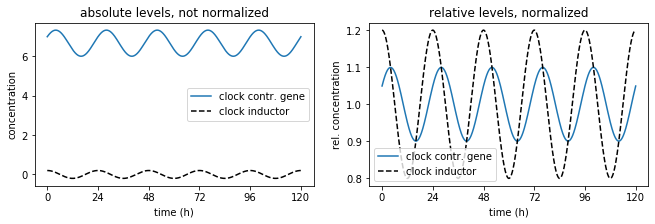

In [18]:
# What happens for small d? <--> long half life, long-lived gene
# --------------------------------------------------------------
# define time, parameters and initial conditions for integration
dt = 0.01
t = np.arange(0, 120, dt)
y0 = 6.995 
parameters = {'a': 1, 'A': 0.2, 'd': 0.15}

# solve ODE model
sol = odeint(ccg, y0, t, args=(parameters,))
rhythmic_input = rhythmic_induction(t, parameters)

# normalize to 1
sol_norm = sol/sol[-int(24/dt):].mean()
rhythmic_input_norm = rhythmic_input + 1

# plot solution 
# subplot 1: time series
fig1 = plt.figure(figsize=(11,3))

ax1 = fig1.add_subplot(121)
ax1.plot(t, sol, label='clock contr. gene', c='dodgerblue')
ax1.plot(t, rhythmic_input, '--', label='clock inductor', c='k')
ax1.legend()
ax1.set_xlabel('time (h)'); ax1.set_ylabel('concentration')
ax1.set_xticks([0, 24, 48, 72, 96, 120])
ax1.set_title('absolute levels, not normalized')

ax2 = fig1.add_subplot(122)
ax2.plot(t, sol_norm, label='clock contr. gene', c='dodgerblue')
ax2.plot(t, rhythmic_input_norm, '--', label='clock inductor', c='k')
ax2.legend()
ax2.set_xlabel('time (h)'); ax2.set_ylabel('rel. concentration')
ax2.set_xticks([0, 24, 48, 72, 96, 120])
ax2.set_title('relative levels, normalized')

[2.31350197]


Text(0.5, 1.0, 'relative levels, normalized')

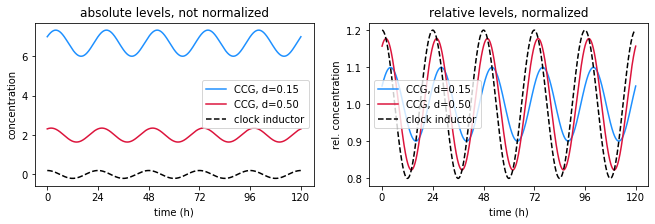

In [26]:
# What happens for large d? <--> short half life, short-lived gene
# ----------------------------------------------------------------
parameters2 = parameters.copy()
parameters2['d'] = 0.5 
y0_2 = 2.3135

sol2 = odeint(ccg, y0_2, t, args=(parameters2,)) # solve ODE
print(sol2[-1])
sol2_norm = sol2/sol2[-int(24/dt):].mean() # normalize to 1

# plot solution 
# subplot 1: time series
fig2 = plt.figure(figsize=(11,3))

ax1 = fig2.add_subplot(121)
ax1.plot(t, sol, label='CCG, d={}'.format(format(parameters['d'], '.2f')), c='dodgerblue')
ax1.plot(t, sol2, label='CCG, d={}'.format(format(parameters2['d'], '.2f')), c='crimson')
ax1.plot(t, rhythmic_input, '--', label='clock inductor', c='k')
ax1.legend()
ax1.set_xlabel('time (h)'); ax1.set_ylabel('concentration')
ax1.set_xticks([0, 24, 48, 72, 96, 120])
ax1.set_title('absolute levels, not normalized')

ax2 = fig2.add_subplot(122)
ax2.plot(t, sol_norm, label='CCG, d={}'.format(format(parameters['d'], '.2f')), c='dodgerblue')
ax2.plot(t, sol2_norm, label='CCG, d={}'.format(format(parameters2['d'], '.2f')), c='crimson')
ax2.plot(t, rhythmic_input_norm, '--', label='clock inductor', c='k')
ax2.legend()
ax2.set_xlabel('time (h)'); ax2.set_ylabel('rel. concentration')
ax2.set_xticks([0, 24, 48, 72, 96, 120])
ax2.set_title('relative levels, normalized')


Text(0, 0.5, 'phase shift (CCG - transcr. activ.) (h)')

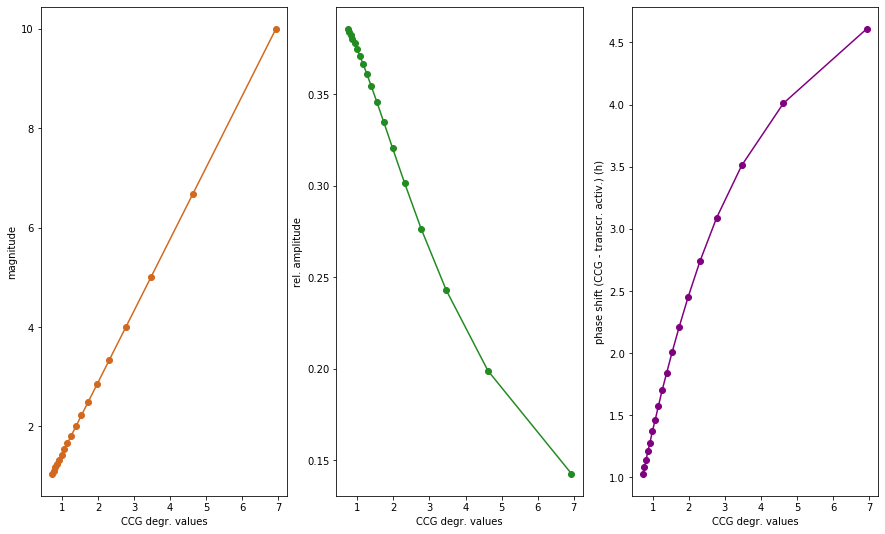

In [37]:
# Systematically increase degradation rate of the CCG and see effect on magnitude, amplitude, phase shift
deg_values = np.arange(0.1, 1, 0.05)
pars = parameters.copy()

magnitudes, rel_amplitudes, phase_shifts = [], [], []
for d in deg_values:
    # change degradation rate value and solve ODE
    pars['d'] = d
    sol = odeint(ccg, y0, t, args=(pars,))

    # calculate magnitude: average oscillating levels after removing transients (in the last 24h)
    magn = sol[-int(24/dt):].mean()
    magnitudes.append(magn)

    # calculate amplitude with peaks and troughs from the normalized solution
    sol_norm = sol/magn
    idx_peaks_x = argrelextrema(sol_norm[:,0], np.greater)[0]
    idx_troughs_x = argrelextrema(sol_norm[:,0], np.less)[0]
    peaks_x, troughs_x = sol_norm[idx_peaks_x], sol_norm[idx_troughs_x]
    relamp = peaks_x[-1] - troughs_x[-1]
    rel_amplitudes.append(relamp)

    # calculate phase shift between CCG and the rhythmic transcriptional activator
    transcriptional_activator = rhythmic_induction(t, pars)
    idx_peaks_txn_activ = argrelextrema(transcriptional_activator, np.greater)[0]
    t_peaks_txn_activ = t[idx_peaks_txn_activ]
    t_peaks_x = t[idx_peaks_x]
    ph_shift = t_peaks_x[-1] - t_peaks_txn_activ[-1]
    ph_shift =+24 if ph_shift < 0 else ph_shift
    phase_shifts.append(ph_shift)

fig3 = plt.figure(figsize=(15,9))
ax1 = fig3.add_subplot(131)
ax2 = fig3.add_subplot(132)
ax3 = fig3.add_subplot(133)
half_lives = np.log(2)/deg_values
ax1.plot(half_lives, magnitudes, 'o-', c='chocolate'); ax1.set_xlabel('CCG degr. values'); ax1.set_ylabel('magnitude')
ax2.plot(half_lives, rel_amplitudes, 'o-', c='forestgreen'); ax2.set_xlabel('CCG degr. values'); ax2.set_ylabel('rel. amplitude')
ax3.plot(half_lives, phase_shifts, 'o-', c='purple'); ax3.set_xlabel('CCG degr. values'); ax3.set_ylabel('phase shift (CCG - transcr. activ.) (h)')

